# Telecom - Churn Forecast
## Description
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts. As such, this is a classification analysis.  
### Interconnect's services
Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.
### Data description
The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.
## Outline
As our analysis outcome is to predict if a customer will churn, this is a classification problem. For this we first need to identify which customers churned. After a preliminary investigation of the raw data we should identify missing and zero values and the distribution of the data. This will help the data manipulation, choosing the best evaluation metric and finally evaluating the different models for churn prediction. 


## Data preparation
### Install and update packages

In [1]:
%%capture

%pip install -U pandas
%pip install -U ipywidgets
%pip install -U ydata-profiling
%pip install -U scikit-learn
%pip install -U lightgbm
%pip install -U xgboost

### Load Packages

In [7]:
import glob
import os

import pandas as pd
import numpy as np

from functools import reduce

from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb
from xgboost import XGBClassifier



### Load Data

In [3]:
telecom_dataset_files = glob.glob("./datasets/telecom/*.csv")

telecom_dataset_dict = {}
for f in telecom_dataset_files:
    root, ext = os.path.splitext(f)
    filename = os.path.basename(root)
    df = pd.read_csv(f)
    telecom_dataset_dict[filename] = df

### Inspect the data

In [8]:
file_names = list(telecom_dataset_dict.keys())
for f in file_names:
    df = telecom_dataset_dict[f]
    profile = ProfileReport(df, title=f, progress_bar=True)
    profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Conclusion:**  
* As what we try to predict is the churn, this meant that our target should be based on the `EndDate` feature. If there is an end date, that means that they failed to become repeat customers. As such, we will add a new `target` column with two categories, if they churned (1) or not (0)
* As we can see from the reports, it appears that there are no missing values in any dataset. However, we identify different number of `customerID`. that suggest, that while each dataset is complete by itself, we don't have all information for each observation. Specifically, our missing values are found in the `internet` and `phone` datasets. as the missing values are found in ~25% percent of all observations, removing those observations can impair our analysis. As such we will first try to identify if there is any trend corresponding to those missing values and fill them accordingly. if there is no trend, we will replace them with a new category. 
* In the `contract` dataset we have the `BeginDate` feature that should be transformed into a `date` type.
* Using the `EndDate` and `BeginDate` features we can evaluate for how long a customer has been with the company. As the `EndDate` feature also contain `No` values (the customer did not churn), will have to replace them with some date. Will use the date of the report (Feb 2nd, 2020).  
* `Total charge` appears to be categorical. we should identify why it is and transform it to numerical. 
* As all of our datasets might help us in the churn prediction, we should merge them into a single dataframe.

## Data preprocessing
### Merging datasets

In [9]:
lst = list(telecom_dataset_dict.values())
data = reduce(lambda x, y: pd.merge(x, y, on = 'customerID', how = 'left'), lst)

display(data.head())

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4     Fiber optic             No           No               No          No   

  StreamingTV StreamingMovies  gender  SeniorCitizen Partner Dependents  \
0          No              No  Female              0     Yes         No   
1          No              No    Male              0      No         No   
2          No              No    Male              0      No         No   
3          No              No    Male              0      No         No   
4          No              No  Female              0      No         No   

  MultipleLines  
0           NaN  
1            No  
2            No  
3           NaN  
4            No

### Converting feature types

In [10]:
# date features
data['BeginDate'] = pd.to_datetime(data['BeginDate'])

In [11]:
# Create a new `EndDate` column, replacing "No" values with the dataset final contract info (Feb 1st, 2020)
data['FinalDate'] = pd.to_datetime(data['EndDate'].replace("No", pd.to_datetime('2020-02-01')))

In [13]:
# Finding how long each customer has been with the company
data['Tenure'] = ((data['FinalDate'] - data['BeginDate']) / np.timedelta64(1,'m'))

In [14]:
# fix the `total charge` feature
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
print(data.isnull().sum())

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
FinalDate              0
Tenure                 0
dtype: int64


After converting the `TotalCharges` feature into a numerical type, we see there are further 11 missing values. they might be a result of white spaces. However, as they are so rare, we will just remove those observations. 

### Creating a target column (churn)

In [15]:
data['churn'] = np.where(data['EndDate']=='No', 0, 1)

### Dealing with missing values

In [16]:
missing_data = (data[data.isnull().any(axis=1)]) # Identifying all rows with missing values
missing_data = pd.DataFrame(np.where(missing_data.isnull(), 1, 0), columns=data.columns) # convert cells with missing data to 1
print(missing_data.sum()) # Sum missing columns

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
FinalDate              0
Tenure                 0
churn                  0
dtype: int64


By checking which features have missing values, it is clear to see that there is a trend. It appears that the missing observations in the `internet` dataset are for the customers who do not have internet (and subsequently, the service provided with an internet connection), while in the `phone` dataset, are the customers that do not have a landline phone. As such, we will fill for each missing observation a new value that describe those observations.

#### Fill missing values

In [17]:
internet_features = telecom_dataset_dict['internet'].drop(columns='customerID').columns
telephone_features = telecom_dataset_dict['phone'].drop(columns='customerID').columns

data[internet_features] = data[internet_features].fillna('No internet service')
data[telephone_features] = data[telephone_features].fillna('No phone service')

# print(data.sum()) # Sum missing columns

#### Removing the missing observations in the `TotalCharges` feature

In [18]:
data.dropna(subset=['TotalCharges'], inplace=True)
print(data.isnull().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
FinalDate           0
Tenure              0
churn               0
dtype: int64


Finally we are done with the missing values. Lets visualize the data

## Data Visualization

In [19]:
c_labels = ['No', 'Yes']
# Create subplots: use 'domain' type for Pie subplot
fig = go.Figure(
    data=[
        go.Pie(
            labels=c_labels, values=data['churn'].value_counts(),
            name="Churn", hole=0.3, textfont_size=16
            )])
fig.update_layout(
    title_text="Churn Distributions")
fig.show()

From this pie chart, we see that we have an imbalance churn distribution. We will have to deal with it. One possibility will be to resample our data (up or down sample). Another method will be to adjust the class weight or change the threshold. These methods will be correct for "simple" models (i.e., logistic regression, decision tree), however, we can also try and use boosting algorithms to deal with the imbalanced data (i.e., XGBoost).  For now, lets continue to inspect our data. We will plot the different features by their respected churn rate.

In [48]:
categorical_features = data.drop(columns=['customerID', 'BeginDate','EndDate','MonthlyCharges','TotalCharges','Tenure','churn','FinalDate']).columns.tolist()
numerical_features = ['MonthlyCharges', 'TotalCharges', 'Tenure']

#### Categorical data

In [49]:
df = pd.melt(data, id_vars=['churn'], value_vars=categorical_features).groupby(['variable','value']).churn.mean().reset_index()

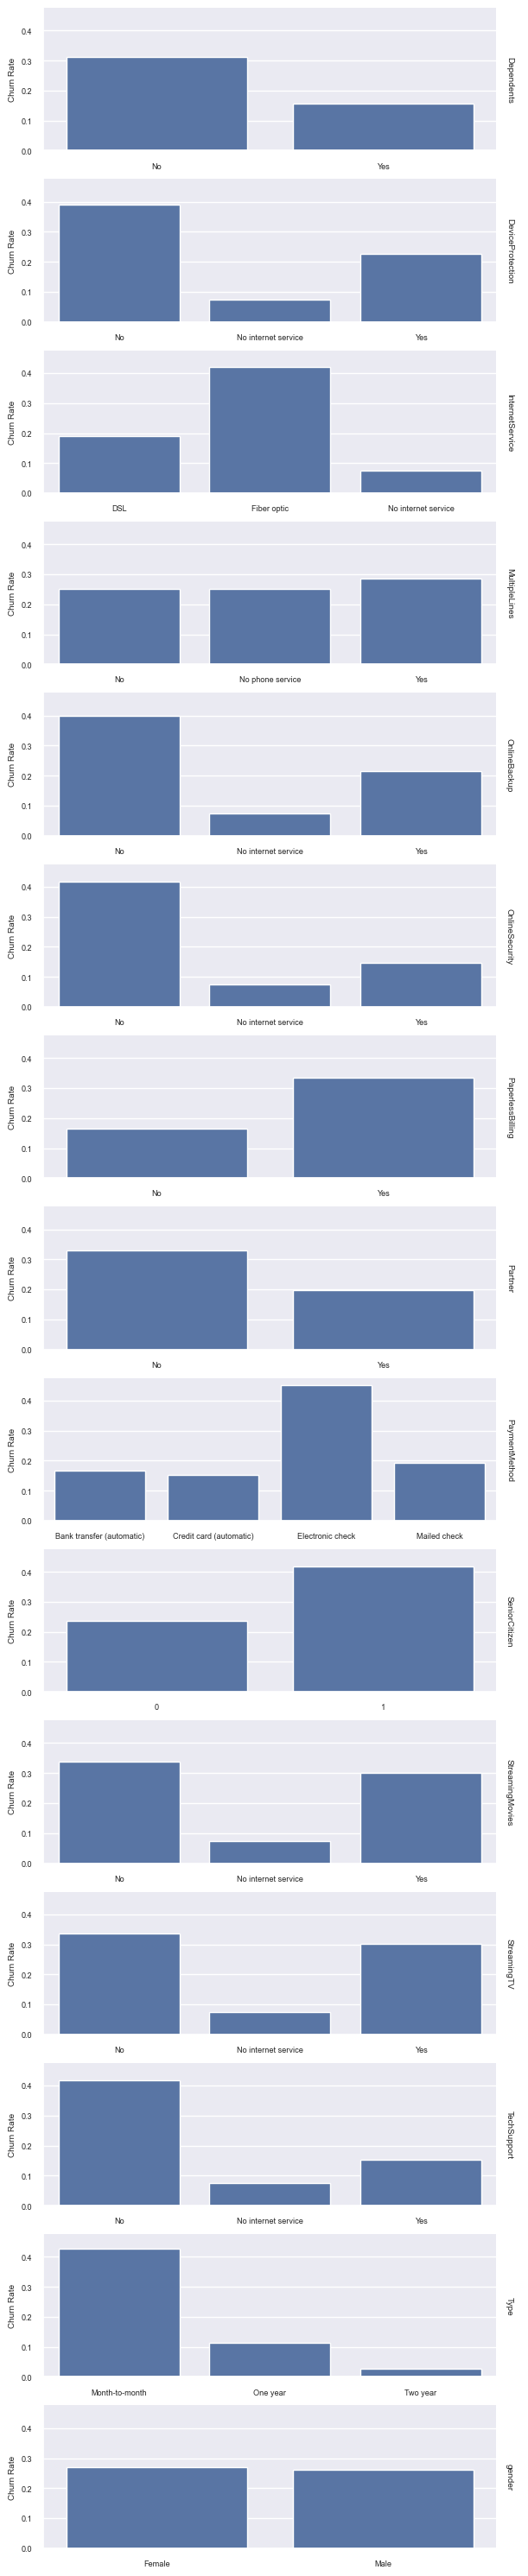

In [58]:
sns.set_theme(font_scale=0.6)
g = sns.catplot(
    data=df,
    x="value", y="churn", row="variable",
    kind="bar", orient="v",
    sharex=False, margin_titles=True,
    height=2, aspect=3
)
g.set(xlabel="", ylabel="Churn Rate")
g.set_titles(row_template="{row_name}")
plt.show()


While we can go over each feature and try to understand what is the underline conclusion regarding them based on the churn rate it is a bit confusing. Well, this is why we want to build our model. However, at least we identify that the churn is not based on gender and it appears that those customers that don't buy extra services are more likely to churn. 

#### Numerical data

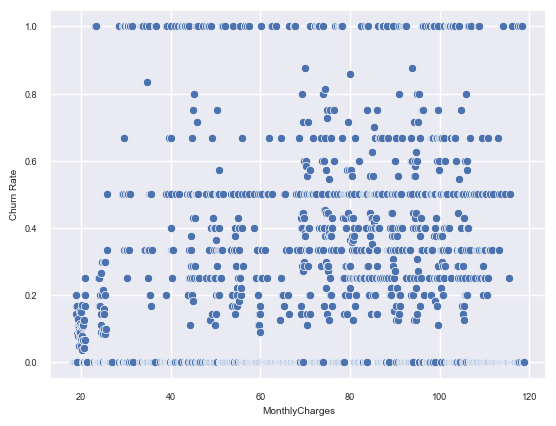

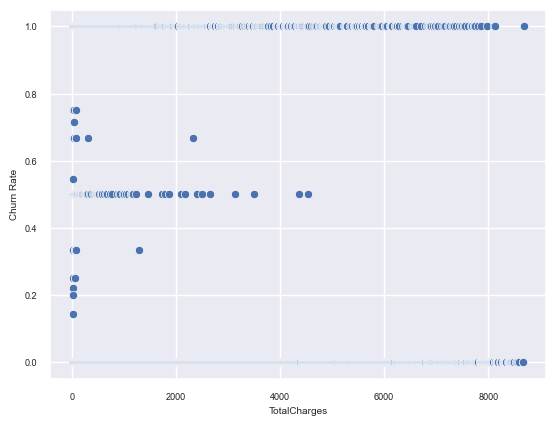

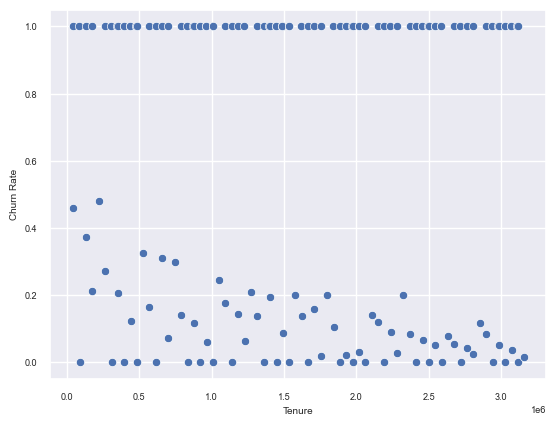

In [63]:
for num in numerical_features:
    df_plot = data.groupby(num).churn.mean().reset_index()
    sns.scatterplot(data=df_plot, x=num, y= 'churn').set(ylabel="Churn Rate")
    plt.show()

It doesn't appear that the charges affect the churn rate. However, it might be beneficial to transform those numerical values into categories. Will try doing it with Kmeans.  
For the tenure, there appear to be a weak trend, where the churn rate decrease with the increase in tenure
 

## Feature engineering
We don't need all columns in the dataset. so lets keep only those that will be in use


In [64]:
data2 = data.copy()
data2 = data2.drop(columns=['customerID','BeginDate', 'EndDate','FinalDate'])
categorical_features2 = categorical_features.copy()

### Transformation of numerics features into categorical
#### MonthlyCharges

In [65]:
%%capture
sse={}
df_cluster = data2[['MonthlyCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 


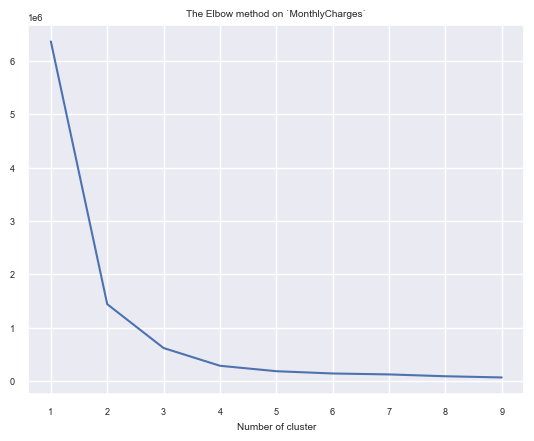

In [66]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.title("The Elbow method on `MonthlyCharges`")
plt.show()

It appears that the data can be separated into 3 clusters

In [67]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data[['MonthlyCharges']])
data2['MonthlyChargeCluster'] = kmeans.predict(data2[['MonthlyCharges']])
data2['MonthlyChargeCluster'] = data2["MonthlyChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})
categorical_features2.append('MonthlyChargeCluster')


#### TotalCharges

In [68]:
%%capture
sse={}
df_cluster = data2[['TotalCharges']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 

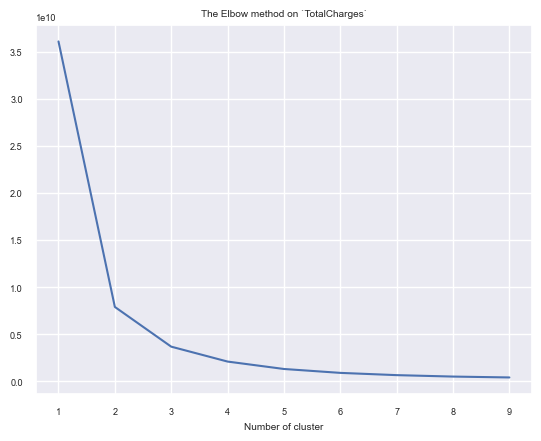

In [69]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.title("The Elbow method on `TotalCharges`")
plt.show()

It appears that the data can be separated into 3 clusters

In [70]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data2[['TotalCharges']])
data2['TotalChargeCluster'] = kmeans.predict(data2[['TotalCharges']])
data2['TotalChargeCluster'] = data2["TotalChargeCluster"].replace({0:'Low',1:'Mid',2:'High'})
categorical_features2.append('TotalChargeCluster')

## Data splitting and feature preparation
### Categorical data encoding

In [71]:
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns

for column in data2.columns:
    if data2[column].dtype == object and column != 'customerID':
        if data2[column].nunique() == 2:
            #apply Label Encoder for binary ones
            data2[column] = le.fit_transform(data2[column]) 
        else:
            dummy_columns.append(column)

#apply get dummies for selected columns
data2 = pd.get_dummies(data = data2,columns = dummy_columns, drop_first=True) 

### Split the data

In [72]:
features = data2.drop(columns=['churn'])
target = data2['churn']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, stratify=target, random_state = 20211113)
print(
    'Ratio between original target values:', round(target.value_counts()[0]/target.value_counts()[1],3),
    '\nRatio between target_train values:', round(target_train.value_counts()[0]/target_train.value_counts()[1],3),
    '\nRatio between target_test values:', round(target_test.value_counts()[0]/target_test.value_counts()[1],3)
    )

Ratio between original target values: 2.762 
Ratio between target_train values: 2.762 
Ratio between target_test values: 2.764


### Numerical feature rescaling: Min-Max scaling

In [73]:
mms = MinMaxScaler()
mms.fit(features_train[numerical_features])

features_train[numerical_features] = mms.transform(features_train[numerical_features])
display(features_train.head())
features_test[numerical_features] = mms.transform(features_test[numerical_features])
display(features_test.head())

PaperlessBilling  MonthlyCharges  TotalCharges  gender  SeniorCitizen  \
1154                 1        0.063682      0.129425       0              0   
4792                 1        0.875622      0.804400       0              1   
4749                 1        0.307960      0.022892       1              0   
5533                 1        0.767662      0.231844       0              1   
2353                 1        0.617910      0.027156       1              0   

      Partner  Dependents    Tenure  Type_One year  Type_Two year  ...  \
1154        1           1  0.620546          False           True  ...   
4792        1           0  0.901897           True          False  ...   
4749        0           0  0.056918          False          False  ...   
5533        0           0  0.282739          False          False  ...   
2353        0           0  0.028690          False          False  ...   

      StreamingTV_No internet service  StreamingTV_Yes  \
1154                             True            False   
4792                            False             True   
4749                            False            False   
5533                            False             True   
2353                            False            False   

      StreamingMovies_No internet service  StreamingMovies_Yes  \
1154                                 True                False   
4792                                False                 True   
4749                                False                False   
5533                                False                 True   
2353                                False                 True   

      MultipleLines_No phone service  MultipleLines_Yes  \
1154                           False               True   
4792                           False               True   
4749                           False              False   
5533                           False               True   
2353                           False              False   

      MonthlyChargeCluster_Low  MonthlyChargeCluster_Mid  \
1154                     False                     False   
4792                     False                      True   
4749                      True                     False   
5533                     False                      True   
2353                     False                      True   

      TotalChargeCluster_Low  TotalChargeCluster_Mid  
1154                   False                   False  
4792                   False                    True  
4749                   False                   False  
5533                    True                   False  
2353                   False                   False  

[5 rows x 33 columns]

PaperlessBilling  MonthlyCharges  TotalCharges  gender  SeniorCitizen  \
256                  0        0.963682      0.807677       0              0   
184                  1        0.606965      0.126288       0              0   
6210                 1        0.363184      0.144165       0              0   
6904                 1        0.254726      0.315728       0              1   
1109                 1        0.317413      0.235704       1              0   

      Partner  Dependents    Tenure  Type_One year  Type_Two year  ...  \
256         1           1  0.845442          False           True  ...   
184         0           0  0.168903          False          False  ...   
6210        0           1  0.338269           True          False  ...   
6904        0           0  0.888015          False          False  ...   
1109        1           0  0.549745          False          False  ...   

      StreamingTV_No internet service  StreamingTV_Yes  \
256                             False             True   
184                             False            False   
6210                            False            False   
6904                            False             True   
1109                            False            False   

      StreamingMovies_No internet service  StreamingMovies_Yes  \
256                                 False                 True   
184                                 False                False   
6210                                False                False   
6904                                False                False   
1109                                False                False   

      MultipleLines_No phone service  MultipleLines_Yes  \
256                            False               True   
184                            False              False   
6210                           False              False   
6904                            True              False   
1109                           False              False   

      MonthlyChargeCluster_Low  MonthlyChargeCluster_Mid  \
256                      False                      True   
184                      False                      True   
6210                      True                     False   
6904                      True                     False   
1109                      True                     False   

      TotalChargeCluster_Low  TotalChargeCluster_Mid  
256                    False                    True  
184                    False                   False  
6210                   False                   False  
6904                    True                   False  
1109                    True                   False  

[5 rows x 33 columns]

In [74]:
# Dropping the `MonthCharges` and `TotalCharges` features as I will be using their categorical interpolation
for df in (features_test, features_train):
    df.drop(columns=['MonthlyCharges', 'TotalCharges'], inplace=True)

## Predictions

### Model selection with hyperparameters tuning


In [75]:
scores_dict = {}
params_dict = {}

#### Logistic regression

In [78]:
params  = {'C': np.arange(0.1,3,0.2), 'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'max_iter': [100,200,1000]}
lr = LogisticRegression(random_state=20211113, class_weight='balanced')
gs_lr = GridSearchCV(lr,param_grid=params, scoring='roc_auc', cv=5, verbose=2)
gs_lr.fit(features_train, target_train)


Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] END ..............C=0.1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=newton-cg; total time=   0.0s
[CV] END ..................C=0.1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, max_iter=100, so

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=20211113),
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9]),
                         'max_iter': [100, 200, 1000],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc', verbose=2)

In [79]:
print("Best model parameters:")
print(gs_lr.best_params_)
params_dict['LR'] = gs_lr.best_params_
print("Best model AUC-ROC:")
print(gs_lr.best_score_)
scores_dict['LR'] = gs_lr.best_score_

Best model parameters:
{'C': 2.900000000000001, 'max_iter': 100, 'solver': 'newton-cg'}
Best model AUC-ROC:
0.8439379600619524


#### Random forest

In [31]:
params  = {'n_estimators': [10,100,1000], 
           'max_depth': [10,100,1000], 
           'max_features': ['sqrt','log2'], 
           'criterion': ['gini','entropy'], 
           'class_weight': ['balanced', 'balanced_subsample']}
rf = RandomForestClassifier(random_state=20211113)
gs_rf = GridSearchCV(rf,param_grid=params, scoring='roc_auc', cv=5, verbose=2)
gs_rf.fit(features_train, target_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=10; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END class_weight=balanced, criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.1s

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=20211113),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 100, 1000],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100, 1000]},
             scoring='roc_auc', verbose=2)

In [82]:
print("Best model parameters:")
print(gs_rf.best_params_)
params_dict['RF'] = gs_rf.best_params_
print("Best model AUC-ROC:")
print(gs_rf.best_score_)
scores_dict['RF'] = gs_rf.best_score_

Best model parameters:
{'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 1000}
Best model AUC-ROC:
0.8553928621941115


#### Support Vector Machine

In [83]:
params  = {'C': [0.1,0.5,1,2], 'kernel': ['linear','rbf']}
svm = SVC(random_state=20211113, class_weight='balanced',probability=True)
gs_svm = GridSearchCV(svm,param_grid=params, scoring='roc_auc', cv=5, verbose=2)
gs_svm.fit(features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   2.9s
[CV] END ...............................C=0.1, kernel=linear; total time=   2.8s
[CV] END ...............................C=0.1, kernel=linear; total time=   2.9s
[CV] END ...............................C=0.1, kernel=linear; total time=   2.8s
[CV] END ...............................C=0.1, kernel=linear; total time=   2.8s
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.6s
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.7s
[CV] END ...............................C=0.5, kernel=linear; total time=   2.5s
[CV] END ...............................C=0.5, ke

GridSearchCV(cv=5,
             estimator=SVC(class_weight='balanced', probability=True,
                           random_state=20211113),
             param_grid={'C': [0.1, 0.5, 1, 2], 'kernel': ['linear', 'rbf']},
             scoring='roc_auc', verbose=2)

In [84]:
print("Best model parameters:")
print(gs_svm.best_params_)
params_dict['SVM'] = gs_svm.best_params_
print("Best model AUC-ROC:")
print(gs_svm.best_score_)
scores_dict['SVM'] = gs_svm.best_score_

Best model parameters:
{'C': 0.1, 'kernel': 'linear'}
Best model AUC-ROC:
0.8388681819666914


#### LightGBM

In [85]:
%%capture --no-stdout
lgb_model = lgb.LGBMClassifier(
    class_weight='balanced',
    boosting_type="gbdt",
    reg_sqrt='True',
    metric ='none',
    max_depth=-1,
    random_state=20221113)

parameters = {
    'learning_rate':[0.1,0.01,0.001],
    'num_leaves':[15,31,45],
    'n_estimators':[100,200,1000],
    'num_iterations': [100,500,1000]
}

gs_lgb = GridSearchCV(lgb_model, param_grid = parameters, cv=5, scoring='roc_auc', verbose=2)
gs_lgb.fit(features_train,target_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.1, n_estimators=100, num_iterations=100, num_leaves=15; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, num_iterations=100, num_leaves=15; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, num_iterations=100, num_leaves=15; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, num_iterations=100, num_leaves=15; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, num_iterations=100, num_leaves=15; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, num_iterations=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, num_iterations=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, num_iterations=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, n_estimators=100, num_iterations=100, num_leaves=31; total time=   0.0s
[CV] END learning_rate=0.1, n_estimato

In [86]:
print("Best model parameters:")
print(gs_lgb.best_params_)
params_dict['LGB'] = gs_lgb.best_params_

print("Best model AUC-ROC:")
print(gs_lgb.best_score_)
scores_dict['LGB'] = gs_lgb.best_score_

Best model parameters:
{'learning_rate': 0.1, 'n_estimators': 100, 'num_iterations': 500, 'num_leaves': 15}
Best model AUC-ROC:
0.9144758130729089


#### XGBoost

In [76]:

pos_weight_estimate = target.value_counts()[0] / target.value_counts()[1]
parameters = {
        'learning_rate': [0.01,0.1,0.3],
        'gamma': [0, 1],
        'max_depth': [1, 6, 10], 
        'min_child_weight': [0.5, 1, 5],  
        'subsample': [0.5, 1.0]
        }
xgb_model = XGBClassifier(objective='binary:logistic', seed=20211113, scale_pos_weight=pos_weight_estimate)

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=20211113)
gs_xgb = GridSearchCV(xgb_model, param_grid = parameters, cv=cv, scoring='roc_auc', verbose=2)
gs_xgb.fit(features_train,target_train)

Fitting 15 folds for each of 108 candidates, totalling 1620 fits
[CV] END gamma=0, learning_rate=0.01, max_depth=1, min_child_weight=0.5, subsample=0.5; total time=   1.7s
[CV] END gamma=0, learning_rate=0.01, max_depth=1, min_child_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=1, min_child_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=1, min_child_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=1, min_child_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=1, min_child_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=1, min_child_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=1, min_child_weight=0.5, subsample=0.5; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_depth=1, min_child_weight=0.5, subsam

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=20211113),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, i...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0, 1], 'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [1, 6, 10],
                         'min_child_weight': [0.5, 1, 5],
                         'subsample': [0.5, 1.0]},
             scoring='roc_auc', verbose=2)

In [77]:
print("Best model parameters:")
print(gs_xgb.best_params_)
params_dict['XGB'] = gs_xgb.best_params_
print("Best model AUC-ROC:")
print(gs_xgb.best_score_)
scores_dict['XGB'] = gs_xgb.best_score_

Best model parameters:
{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 0.5, 'subsample': 1.0}
Best model AUC-ROC:
0.9240089599003999


#### Evaluate models

In [78]:
print("Best model based on AUC-ROC score:")
print(max(scores_dict,key=scores_dict.get))
print("with a score of:")
print(round(max(scores_dict.values()),3))
print(f'Best parameter for the {max(scores_dict,key=scores_dict.get)} model are:')
print(params_dict.get(max(scores_dict,key=scores_dict.get)))


Best model based on AUC-ROC score:
XGB
with a score of:
0.924
Best parameter for the XGB model are:
{'gamma': 0, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 0.5, 'subsample': 1.0}


#### Features importance

In [79]:
display(
    pd.DataFrame(
        gs_xgb.best_estimator_.feature_importances_,
        index=features_test.columns, 
        columns=['FeatureImportance']).
        sort_values(by=['FeatureImportance'],ascending=False).head(10)
)

FeatureImportance
Type_Two year                                 0.500511
Type_One year                                 0.124313
InternetService_Fiber optic                   0.054997
InternetService_No internet service           0.048355
Tenure                                        0.025560
StreamingMovies_Yes                           0.025156
MultipleLines_No phone service                0.016606
TotalChargeCluster_Low                        0.016078
PaymentMethod_Electronic check                0.013784
StreamingTV_Yes                               0.013571

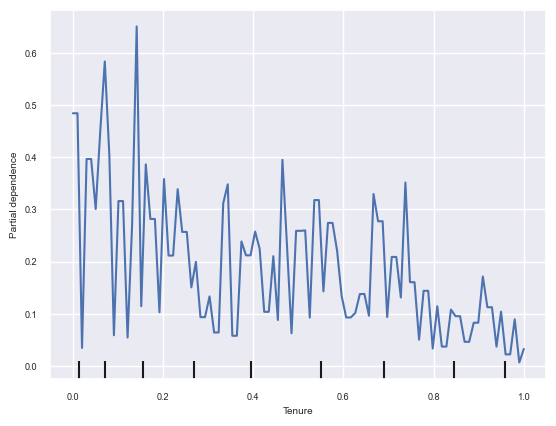

In [83]:
from sklearn.inspection import PartialDependenceDisplay
var = 'Tenure'
PartialDependenceDisplay.from_estimator(gs_xgb.best_estimator_, features_train, [var]);

#### Test model

In [120]:
pred_proba = gs_xgb.predict_proba(features_test)[:, 1]
roc_auc = metrics.roc_auc_score(target_test, pred_proba)
print(f'The AUC-ROC score for the {max(scores_dict,key=scores_dict.get)} model is:')
print(round(roc_auc,3))

The AUC-ROC score for the XGB model is:
0.92


## Solution report
 
The plan was first to investigate the different datasets, combining them and replacing or omitting any problematic value. Next, the target value (churn) was created, and the data was visualized to identify any trend regarding our data. The most important observation was finding out that our data is highly imbalanced. Later, feature engineering steps were performed. This step was essential in increasing our models' predictive power. It included extracting new features from the data we already have (for example, tenure) and scaling and resampling our features. Lastly, different classification models were investigated, each with unique hyperparameter tunings. While this step can be crucial, it was found that selecting a model correctly for the analysis and combining it with the right features is more critical than hyperparameter tuning.

> What were some of the key steps to solving the task?

The key steps were:
1. Fix problematic values
2. Add to the model complexity by adding features (the MOST important step)
3. Feature engineering

> What is the final model and what quality score does it have?

For the final model, I chose to use the XGBoost model with a `binary:logistic`. Handling data imbalance was done using the `scale_pos_weight` parameter by increasing the weight of the less abundant class. Furthermore, while other hyperparameters were investigated, the improvement of the model was minor. This model resulted in an AUC-ROC score of 0.926.  
We identified that the most important feature was the type of contract a customer buys. From this, we can see that the customers most likely to churn are those who buy a month-to-month contract which might suggest the company to focus on the month-to-month customers, and convert them to have a different plan.